In [37]:
import pandas as pd
import optbinning as ob
import sklearn as sl
from optbinning import OptimalBinning, BinningProcess
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
import ydata_profiling
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from ydata_profiling import ProfileReport
import category_encoders as ce
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.feature_selection import mutual_info_regression
from datetime import datetime
import seaborn as sns
from category_encoders import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

<h1>Практическое задание</h1>

*Reading data*

In [2]:
read = pd.read_csv('D:/maga_1/ML/data/external/all_v2.csv', index_col= False)
print(read)

            price        date      time    geo_lat    geo_lon  region  \
0         6050000  2018-02-19  20:00:21  59.805808  30.376141    2661   
1         8650000  2018-02-27  12:04:54  55.683807  37.297405      81   
2         4000000  2018-02-28  15:44:00  56.295250  44.061637    2871   
3         1850000  2018-03-01  11:24:52  44.996132  39.074783    2843   
4         5450000  2018-03-01  17:42:43  55.918767  37.984642      81   
...           ...         ...       ...        ...        ...     ...   
5477001  19739760  2021-05-01  20:13:58  55.804736  37.750898       3   
5477002  12503160  2021-05-01  20:14:01  55.841415  37.489624       3   
5477003   8800000  2021-05-01  20:14:04  56.283909  44.075408    2871   
5477004  11831910  2021-05-01  20:14:12  55.804736  37.750898       3   
5477005  13316200  2021-05-01  20:14:15  55.860240  37.540356       3   

         building_type  level  levels  rooms  area  kitchen_area  object_type  
0                    1      8      10      

In [3]:
regions = read[read["region"] == 2661]
regions = regions.drop_duplicates()
print(regions)

            price        date      time    geo_lat    geo_lon  region  \
0         6050000  2018-02-19  20:00:21  59.805808  30.376141    2661   
7         3600000  2018-03-04  20:52:38  59.875526  30.395457    2661   
36        3200000  2018-04-10  16:10:12  59.827465  30.201827    2661   
47        6500000  2018-04-23  11:47:58  59.988334  29.786928    2661   
54        6300000  2018-04-28  17:47:24  59.911622  30.284556    2661   
...           ...         ...       ...        ...        ...     ...   
5476909   8000000  2021-05-01  19:56:37  59.951248  30.492657    2661   
5476937  12500000  2021-05-01  20:02:37  59.853716  30.396701    2661   
5476949  30000000  2021-05-01  20:04:42  59.961501  30.255689    2661   
5476964   9600000  2021-05-01  20:08:40  59.907618  30.322752    2661   
5476998   4900000  2021-05-01  20:13:43  59.850103  30.357299    2661   

         building_type  level  levels  rooms  area  kitchen_area  object_type  
0                    1      8      10      

<h3>Filtration</h3>

In [4]:
real_estate = regions.query("area >= 20 and area <= 200")
real_estate = real_estate.query("kitchen_area >= 6 and kitchen_area <= 30")
real_estate = real_estate.query("price >= 1500000 and price <= 50000000")
real_estate.loc[real_estate['rooms'] < 0, 'rooms'] = 0
print(real_estate)

            price        date      time    geo_lat    geo_lon  region  \
0         6050000  2018-02-19  20:00:21  59.805808  30.376141    2661   
7         3600000  2018-03-04  20:52:38  59.875526  30.395457    2661   
36        3200000  2018-04-10  16:10:12  59.827465  30.201827    2661   
47        6500000  2018-04-23  11:47:58  59.988334  29.786928    2661   
54        6300000  2018-04-28  17:47:24  59.911622  30.284556    2661   
...           ...         ...       ...        ...        ...     ...   
5476909   8000000  2021-05-01  19:56:37  59.951248  30.492657    2661   
5476937  12500000  2021-05-01  20:02:37  59.853716  30.396701    2661   
5476949  30000000  2021-05-01  20:04:42  59.961501  30.255689    2661   
5476964   9600000  2021-05-01  20:08:40  59.907618  30.322752    2661   
5476998   4900000  2021-05-01  20:13:43  59.850103  30.357299    2661   

         building_type  level  levels  rooms  area  kitchen_area  object_type  
0                    1      8      10      

In [14]:
#Добавление полей
real_estate['first_floor'] = np.where(real_estate['level'] == 1, 1, 0)
# Добавляем столбец last_floor
real_estate['last_floor'] = np.where(real_estate['level'] == real_estate['levels'], 1, 0)
real_estate['ratio'] = np.where(real_estate['rooms'] == 0, real_estate['area'], real_estate['kitchen_area']/real_estate['area'])
# if (real_estate['rooms'] == 0):
#     real_estate['ratio'] = real_estate['area']
# else:
#     real_estate['ratio'] = real_estate['kitchen_area']/real_estate['area']
now = "2021-05-01"
real_estate['remoteness'] = (pd.to_datetime("2021-05-01") - pd.to_datetime(real_estate['date'])).dt.days

                  price   geo_lat   geo_lon  region  building_type     level  \
price          1.000000  0.059833 -0.069024     NaN       0.076795 -0.076729   
geo_lat        0.059833  1.000000 -0.159242     NaN      -0.046737  0.136494   
geo_lon       -0.069024 -0.159242  1.000000     NaN      -0.074603  0.054263   
region              NaN       NaN       NaN     NaN            NaN       NaN   
building_type  0.076795 -0.046737 -0.074603     NaN       1.000000 -0.071473   
level         -0.076729  0.136494  0.054263     NaN      -0.071473  1.000000   
levels        -0.177449  0.221615  0.086298     NaN      -0.127936  0.599799   
rooms          0.524587 -0.007327 -0.011766     NaN       0.057506 -0.136002   
area           0.780178  0.015442 -0.062527     NaN       0.092706 -0.095116   
kitchen_area   0.490276  0.045437 -0.072607     NaN       0.042541  0.049654   
object_type   -0.021370  0.083628  0.017299     NaN      -0.029026  0.145415   
first_floor   -0.060694 -0.064914 -0.003

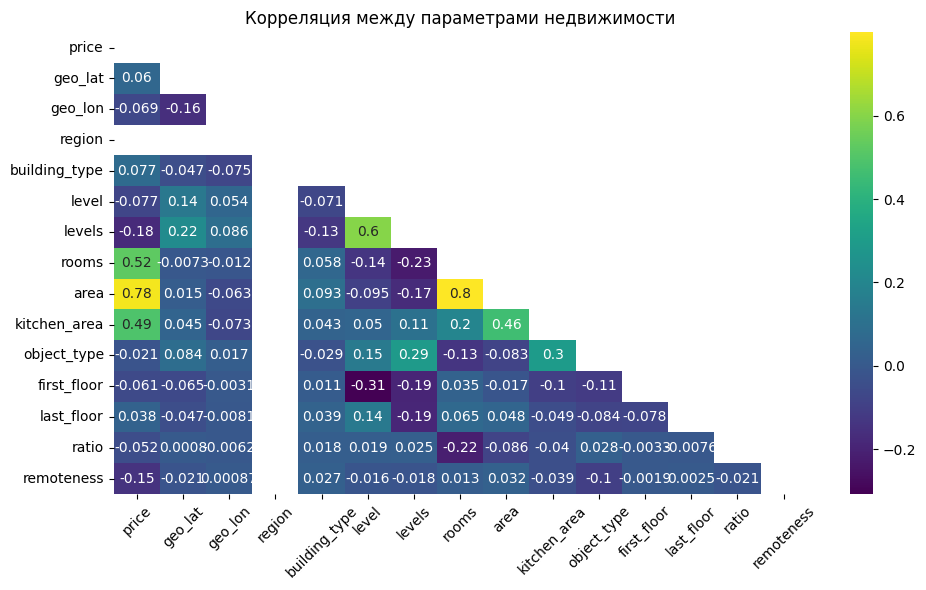

In [19]:
real_estate_corr = real_estate[["price", "geo_lat", "geo_lon", "region", "building_type", "level", "levels", "rooms", "area", "kitchen_area", "object_type", "first_floor", "last_floor", "ratio", "remoteness"]]
corr_matrix = real_estate_corr.corr()
print(corr_matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='viridis',
    mask=np.triu(np.ones_like(corr_matrix))  # Скрыть верхний треугольник
)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Корреляция между параметрами недвижимости")
plt.tight_layout()
plt.show()

In [30]:
# Выделяем категориальные признаки
categorical_cols = ['building_type', 'object_type', 'region']
# Инициализируем энкодер
encoder = BinaryEncoder(cols=categorical_cols)
# Кодируем данные
real_estate_encoded = encoder.fit_transform(real_estate_corr)
print(real_estate_encoded.head())

      price    geo_lat    geo_lon  region_0  building_type_0  building_type_1  \
0   6050000  59.805808  30.376141         1                0                0   
7   3600000  59.875526  30.395457         1                0                0   
36  3200000  59.827465  30.201827         1                0                0   
47  6500000  59.988334  29.786928         1                0                1   
54  6300000  59.911622  30.284556         1                0                1   

    building_type_2  level  levels  rooms  area  kitchen_area  object_type_0  \
0                 1      8      10      3  82.6          10.8              0   
7                 1      2       5      1  31.1           6.0              0   
36                1      7       9      1  31.0           7.0              0   
47                0      3       3      3  89.0          10.0              0   
54                0      5       5      2  99.9          14.5              0   

    object_type_1  first_floor  

In [31]:
X = real_estate_encoded.drop('price', axis=1)  # Все колонки, кроме целевой
y = real_estate_encoded['price']               # Целевая переменная (цена)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

# Проверка размеров
print(f"Обучающая выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")

Обучающая выборка: 328384 записей
Тестовая выборка: 82097 записей


In [33]:
numeric_features = ['geo_lat', 'geo_lon', 'area', 'kitchen_area', 'levels', 'rooms']
binary_features = [col for col in X_train.columns if col not in numeric_features]

scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_features])
X_test_numeric = scaler.transform(X_test[numeric_features])

X_train_scaled = pd.DataFrame(
    X_train_numeric, 
    columns=numeric_features, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    X_test_numeric, 
    columns=numeric_features, 
    index=X_test.index
)
X_train_final = pd.concat([
    X_train_scaled, 
    X_train[binary_features]
], axis=1)
X_test_final = pd.concat([
    X_test_scaled, 
    X_test[binary_features]
], axis=1)


ridge_model = Ridge(alpha=1.0, random_state=42)  # alpha = сила регуляризации
ridge_model.fit(X_train_final, y_train)

y_pred = ridge_model.predict(X_test_final)

print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

MSE: 7769578509407.76
R²: 0.6946



Результаты:
MSE: 3901035744964.04
R²: 0.8467


<Figure size 1200x600 with 0 Axes>

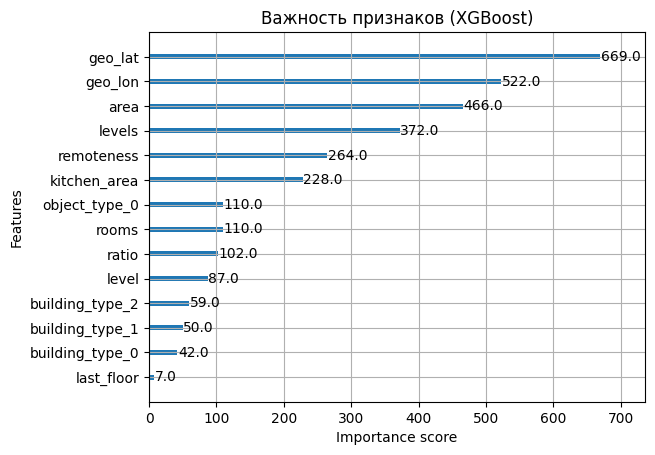

In [36]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Для задачи регрессии
    random_state=42,
    n_estimators=100,             # Количество деревьев
    max_depth=5,                   # Глубина деревьев
    learning_rate=0.1              # Скорость обучения
)

xgb_model.fit(X_train_final, y_train)

y_pred = xgb_model.predict(X_test_final)

print("\nРезультаты:")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Важность признаков (XGBoost)')
plt.show()

In [40]:
print(f"Минимальная цена: {real_estate['price'].min()}")
print(f"Количество нулевых или отрицательных цен: {(real_estate['price'] <= 0).sum()}")

Минимальная цена: 1500000
Количество нулевых или отрицательных цен: 0


In [41]:
def calculate_metrics(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_pred = np.maximum(y_train_pred, 1e-6)
    y_test_pred = np.maximum(y_test_pred, 1e-6)
    train_metrics = {
        'RMSLE': np.sqrt(mean_squared_log_error(y_train, y_train_pred)),
        'R2': r2_score(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred)
    }

    test_metrics = {
        'RMSLE': np.sqrt(mean_squared_log_error(y_test, y_test_pred)),
        'R2': r2_score(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred)
    }

    return train_metrics, test_metrics

ridge_train_metrics, ridge_test_metrics = calculate_metrics(ridge_model, X_train_final, X_test_final, y_train, y_test)
xgb_train_metrics, xgb_test_metrics = calculate_metrics(xgb_model, X_train_final, X_test_final, y_train, y_test)

results = pd.DataFrame({
    'Ridge (Train)': ridge_train_metrics,
    'Ridge (Test)': ridge_test_metrics,
    'XGBoost (Train)': xgb_train_metrics,
    'XGBoost (Test)': xgb_test_metrics
}).T

results.style.format({
    'RMSLE': '{:.3f}',
    'R2': '{:.3f}',
    'MAE': '{:,.0f}'
})

,RMSLE,R2,MAE
Ridge (Train),0.532,0.695,"1,697,223"
Ridge (Test),0.538,0.695,"1,692,948"
XGBoost (Train),0.191,0.852,"1,073,741"
XGBoost (Test),0.192,0.847,"1,079,668"


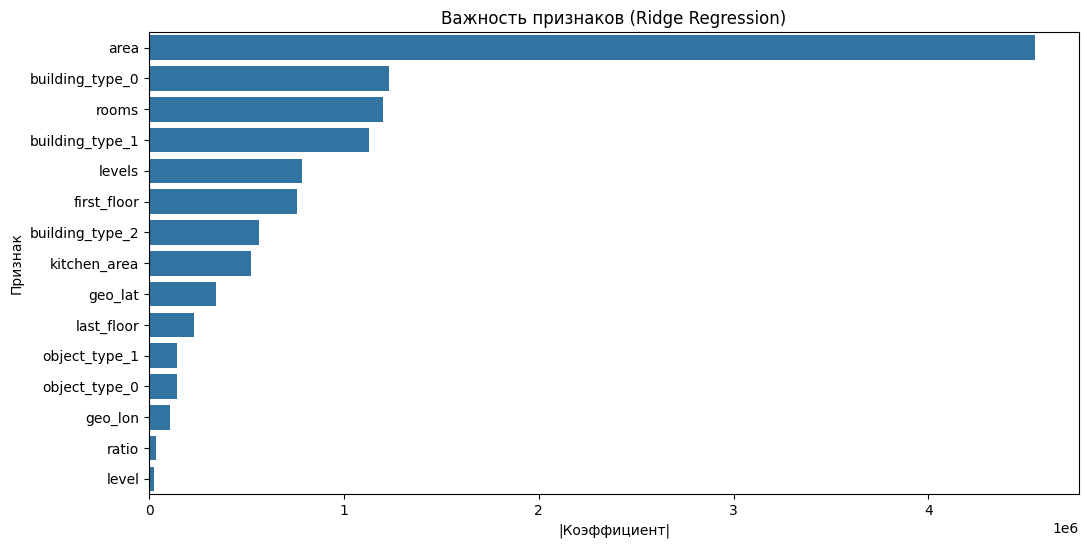

In [42]:
coefs = pd.DataFrame({
    'feature': X_train_final.columns,
    'coef_abs': np.abs(ridge_model.coef_),
    'coef': ridge_model.coef_
})

# Сортировка по важности
coefs_sorted = coefs.sort_values('coef_abs', ascending=False)

# Визуализация топ-15 признаков
plt.figure(figsize=(12, 6))
sns.barplot(x='coef_abs', y='feature', data=coefs_sorted.head(15))
plt.title("Важность признаков (Ridge Regression)")
plt.xlabel("|Коэффициент|")
plt.ylabel("Признак")
plt.show()

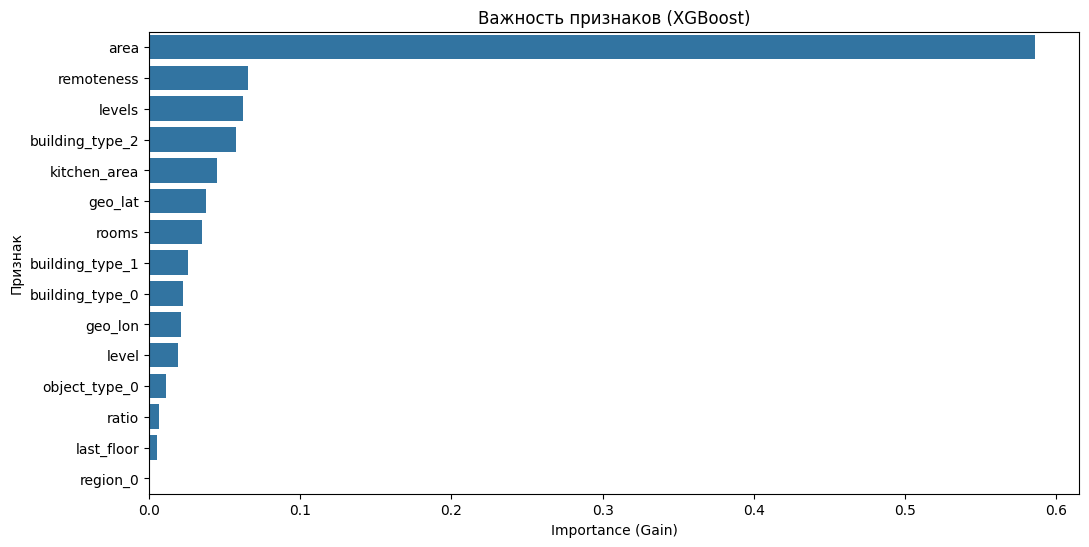

In [43]:
feature_importance = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': xgb_model.feature_importances_
})

# Сортировка по важности
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Визуализация топ-15 признаков
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title("Важность признаков (XGBoost)")
plt.xlabel("Importance (Gain)")
plt.ylabel("Признак")
plt.show()


In [44]:
ridge_top = coefs_sorted.head(10)['feature'].tolist()

# Топ-10 для XGBoost
xgb_top = feature_importance.head(10)['feature'].tolist()

# Общие признаки
common_features = set(ridge_top).intersection(xgb_top)

print("Топ-10 признаков Ridge:")
print(ridge_top)
print("\nТоп-10 признаков XGBoost:")
print(xgb_top)
print("\nОбщие признаки:")
print(common_features)

Топ-10 признаков Ridge:
['area', 'building_type_0', 'rooms', 'building_type_1', 'levels', 'first_floor', 'building_type_2', 'kitchen_area', 'geo_lat', 'last_floor']

Топ-10 признаков XGBoost:
['area', 'remoteness', 'levels', 'building_type_2', 'kitchen_area', 'geo_lat', 'rooms', 'building_type_1', 'building_type_0', 'geo_lon']

Общие признаки:
{'kitchen_area', 'building_type_1', 'building_type_0', 'building_type_2', 'levels', 'rooms', 'geo_lat', 'area'}


In [45]:
print(X_test_final.columns)

Index(['geo_lat', 'geo_lon', 'area', 'kitchen_area', 'levels', 'rooms',
       'region_0', 'building_type_0', 'building_type_1', 'building_type_2',
       'level', 'object_type_0', 'object_type_1', 'first_floor', 'last_floor',
       'ratio', 'remoteness'],
      dtype='object')


In [72]:
Kad_price_today = 11500631.53
custom_data = pd.DataFrame(columns=X_test_final.columns)

custom_input = {
    'area': 34.8,
    'geo_lat': 60.0359,
    'geo_lon': 30.3237,
    'rooms': 1,
    'kitchen_area': 8,
    'levels': 10,
    'region_0': 1,
    'building_type_0': 0,
    'building_type_1': 0, 
    'building_type_2': 1,
    'level': 6,
    'object_type_0': 1, 
    'object_type_1': 0, 
    'first_floor': 0, 
    'last_floor': 0,
    'ratio': 4.7, 
    'remoteness': 21

}

temp_df = pd.DataFrame([custom_input])
custom_data = pd.concat(
    [custom_data, temp_df], 
    axis=0,        # Объединение по строкам
    ignore_index=True
)

custom_data = custom_data.fillna(0)
#print(custom_data)

for col, dtype in X_test_final.dtypes.items():
    custom_data[col] = custom_data[col].astype(dtype)

numeric_features = ['geo_lat', 'geo_lon', 'area', 'kitchen_area', 'levels', 'rooms']
binary_features = [col for col in custom_data.columns if col not in numeric_features]

scaler = StandardScaler()
custom_data_numeric = scaler.fit_transform(custom_data[numeric_features])
# custom_data_numeric = scaler.transform(custom_data[numeric_features])
custom_data_scaled = pd.DataFrame(
    custom_data_numeric, 
    columns=numeric_features, 
    index=custom_data.index
)
custom_data_final = pd.concat([
    custom_data_scaled, 
    custom_data[binary_features]
], axis=1)

prediction = xgb_model.predict(custom_data_final)
print(prediction)
print(prediction*1.3)
print(Kad_price_today)

[10575119.]
[13747654.]
11500631.53


C:\Users\andre\AppData\Local\Temp\ipykernel_23456\279589820.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  custom_data = pd.concat(
C:\Users\andre\AppData\Local\Temp\ipykernel_23456\279589820.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  custom_data = custom_data.fillna(0)


<h1>Самостоятельное задание</h1>

*Reading data*

In [74]:
read = pd.read_csv('D:/maga_1/ML/data/external/move.csv', index_col= False)
print(read)

      Unnamed: 0                         metro  price   way  views  \
0              0                   Planernaia   45000  walk    513   
1              1                        VDNKh   50000  walk    389   
2              2                Alekseevskaia   50000  walk    483   
3              3                     Sviblovo   38000  walk    414   
4              4                     Rimskaia   55999  walk    360   
...          ...                           ...    ...   ...    ...   
1441        1441                    Solntcevo   25000  walk    189   
1442        1442    Ulitca Starokachalovskaia   25000  walk    173   
1443        1443                    Zhulebino   25000  walk    102   
1444        1444   Preobrazhenskaia ploshchad   40000  walk     60   
1445        1445                  Rasskazovka   30000  walk   2728   

                         provider  fee_percent  storey  minutes  storeys  \
0     realtor                               50       7       10       12   
1     r

<h3>Dataset Analysis</h3>

In [75]:
# Удаление пробелов в строковых полях 
read['provider'] = read['provider'].str.strip()

# Преобразование 'total_area' в числовой формат (замена запятых на точки)
#read['total_area'] = read['total_area'].astype(str).str.replace(',', '.').astype(float)

# Удаление дубликатов
print(f"Дубликатов до удаления: {read.duplicated().sum()}")
read = read.drop_duplicates()
print(f"Дубликатов после удаления: {read.duplicated().sum()}")

Дубликатов до удаления: 0
Дубликатов после удаления: 0


<h3>Фильтрация выбросов</h3>

In [76]:
# Расчет Z-показателей для 'price' и 'storeys'
z_scores_price = np.abs(stats.zscore(read['price']))
z_scores_storeys = np.abs(stats.zscore(read['storeys']))

# Фильтрация данных (|Z| < 3)
read = read[(z_scores_price < 3) & (z_scores_storeys < 3)]


# df = df.drop('provider', axis=1)

# Проверка и обработка пропусков (удаление строк с пропусками)
read = read.dropna()
print(read)

      Unnamed: 0                         metro  price   way  views provider  \
0              0                   Planernaia   45000  walk    513  realtor   
1              1                        VDNKh   50000  walk    389  realtor   
2              2                Alekseevskaia   50000  walk    483  realtor   
3              3                     Sviblovo   38000  walk    414  realtor   
4              4                     Rimskaia   55999  walk    360  realtor   
...          ...                           ...    ...   ...    ...      ...   
1441        1441                    Solntcevo   25000  walk    189  realtor   
1442        1442    Ulitca Starokachalovskaia   25000  walk    173  realtor   
1443        1443                    Zhulebino   25000  walk    102  realtor   
1444        1444   Preobrazhenskaia ploshchad   40000  walk     60  realtor   
1445        1445                  Rasskazovka   30000  walk   2728    owner   

      fee_percent  storey  minutes  storeys  living

**Подготовка к построению моделей**

In [77]:

# Разделение на признаки и целевую переменную
X = read.drop('price', axis=1)
y = read['price']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [78]:
encoder = ce.CatBoostEncoder(
    cols=['metro', 'provider', 'way'],  # Теперь два столбца
    sigma=0.1,
    random_state=42
)

# 4. Обучение и применение энкодера
X_train_encoded = encoder.fit_transform(X_train[['metro', 'provider', 'way']], y_train)
X_test_encoded = encoder.transform(X_test[['metro', 'provider', 'way']])
print(X_train_encoded)
# 5. Объединение данных
X_train = pd.concat([
    X_train.drop(['metro', 'provider', 'way'], axis=1),
    X_train_encoded
], axis=1)

X_test = pd.concat([
    X_test.drop(['metro', 'provider', 'way'], axis=1),
    X_test_encoded
], axis=1)
print(X_train_encoded)

             metro      provider           way
490   41074.955507  43457.312158  39545.629134
50    38590.205387  43776.248963  50344.893119
157   41665.737161  35709.563386  49155.404466
830   45091.057236  42128.408240  39042.851672
1160  48404.541307  60156.183964  56954.372319
...            ...           ...           ...
1129  39265.338374  39410.169826  38421.204264
1166  25484.810758  36780.331170  39374.231559
1335  39744.846427  33205.676388  30736.202503
886   45094.137666  35217.092264  41838.459867
1162  42030.368713  42451.113250  35223.776584

[1120 rows x 3 columns]
             metro      provider           way
490   41074.955507  43457.312158  39545.629134
50    38590.205387  43776.248963  50344.893119
157   41665.737161  35709.563386  49155.404466
830   45091.057236  42128.408240  39042.851672
1160  48404.541307  60156.183964  56954.372319
...            ...           ...           ...
1129  39265.338374  39410.169826  38421.204264
1166  25484.810758  36780.331170  3

<h3>Построение моделей</h3>

In [79]:
RandFor = RandomForestRegressor(n_estimators=100)
XGBoost = XGBRegressor(booster = "gbtree")
ExtraTr = ExtraTreesRegressor(n_estimators=100)

RandFor.fit(X_train, y_train)
y_pred_rf = RandFor.predict(X_test)

XGBoost.fit(X_train, y_train)
y_pred_xgb = XGBoost.predict(X_test)

ExtraTr.fit(X_train, y_train)
y_pred_et = ExtraTr.predict(X_test)

<h3>Метрики</h3>

In [81]:
#RandomForest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("MAE Random Forest")
print(mae_rf)



#XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("MAE XGBoost")
print(mae_xgb)

#ExtraTree
mae_et = mean_absolute_error(y_test, y_pred_et)
mse_et = mean_squared_error(y_test, y_pred_et)
r2_et = r2_score(y_test, y_pred_et)
print("MAE ExtraTree")
print(mae_et)


MAE Random Forest
1241.426797153025
MAE XGBoost
1563.8477744105871
MAE ExtraTree
1326.4079359430605


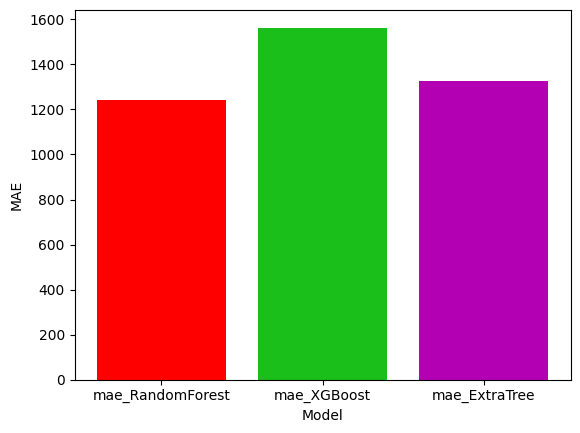

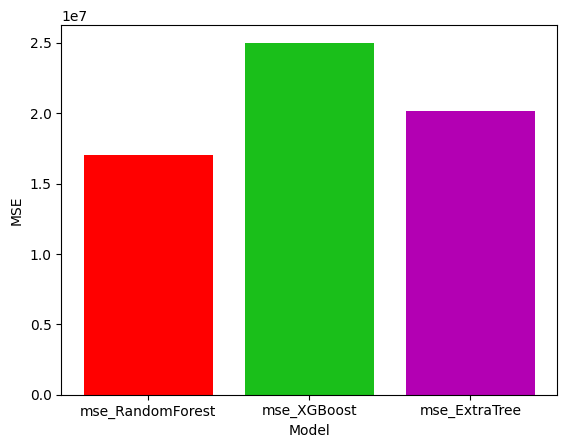

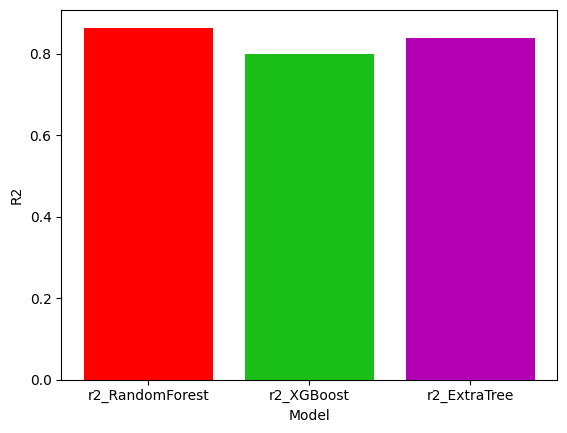

In [82]:
plt.bar("mae_RandomForest", mae_rf, color = (1.0, 0, 0))
plt.bar("mae_XGBoost", mae_xgb, color = (0.1, 0.75, 0.1))
plt.bar("mae_ExtraTree", mae_et, color = (0.7, 0, 0.7))
plt.xlabel("Model")
plt.ylabel("MAE")
plt.show()

plt.bar("mse_RandomForest", mse_rf, color = (1.0, 0, 0))
plt.bar("mse_XGBoost", mse_xgb, color = (0.1, 0.75, 0.1))
plt.bar("mse_ExtraTree", mse_et, color = (0.7, 0, 0.7))
plt.xlabel("Model")
plt.ylabel("MSE")
plt.show()

plt.bar("r2_RandomForest", r2_rf, color = (1.0, 0, 0))
plt.bar("r2_XGBoost", r2_xgb, color = (0.1, 0.75, 0.1))
plt.bar("r2_ExtraTree", r2_et, color = (0.7, 0, 0.7))
plt.xlabel("Model")
plt.ylabel("R2")
plt.show()

<h3>Значимость признаков</h3>

              Unnamed: 0     views  fee_percent    storey   minutes   storeys  \
Unnamed: 0      1.000000  0.095172    -0.012401 -0.097065  0.041000 -0.074308   
views           0.095172  1.000000    -0.072207 -0.057628  0.232680 -0.201395   
fee_percent    -0.012401 -0.072207     1.000000 -0.061105  0.038583  0.118269   
storey         -0.097065 -0.057628    -0.061105  1.000000 -0.168888  0.372519   
minutes         0.041000  0.232680     0.038583 -0.168888  1.000000 -0.288600   
storeys        -0.074308 -0.201395     0.118269  0.372519 -0.288600  1.000000   
living_area    -0.231039 -0.109741    -0.168443  0.018028 -0.058985  0.018157   
kitchen_area   -0.228376 -0.139306    -0.097315 -0.011289 -0.010707 -0.035305   
way            -0.008229  0.007500    -0.013574 -0.065082 -0.009649  0.018522   

              living_area  kitchen_area       way  
Unnamed: 0      -0.231039     -0.228376 -0.008229  
views           -0.109741     -0.139306  0.007500  
fee_percent     -0.168443     -0.

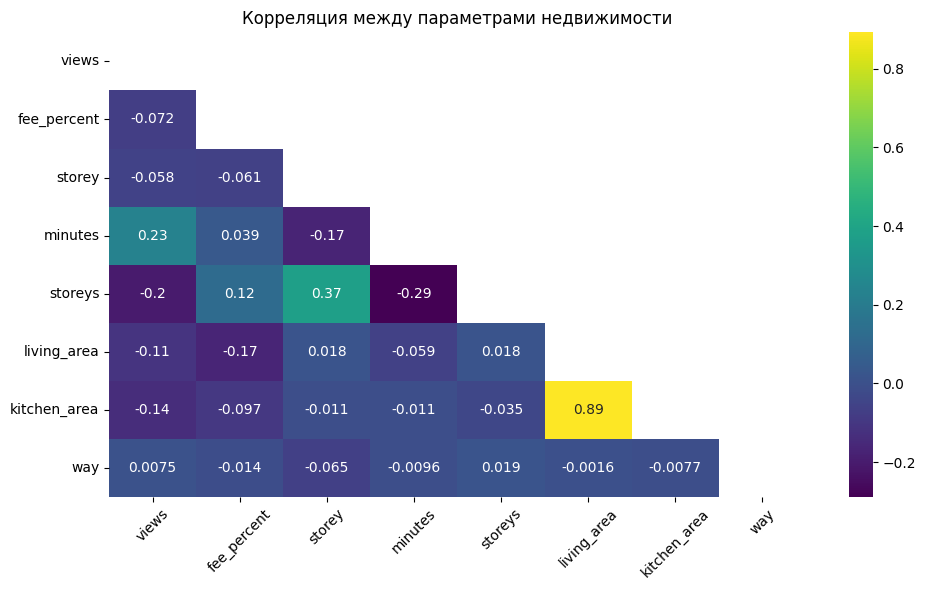

In [88]:


# # Расчет MI для всех признаков
# X = read[['metro', 'provider', 'total_area']]
# X_encoded = pd.get_dummies(X)  # Для категориальных признаков

# mi = mutual_info_regression(X_encoded, read['price'])
# mi_scores = pd.Series(mi, index=X_encoded.columns).sort_values(ascending=False)
# print("Взаимная информация:\n", mi_scores)
corr_mat = X_train.drop(['metro', 'provider', 'total_area'],axis = 1)
corr = corr_mat.corr()
print(corr)
X_train_corr = X_train[["views", "fee_percent", "storey", "minutes", "storeys", "living_area", "kitchen_area", "way"]]
corr_matrix = X_train_corr.corr()
print(corr_matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='viridis',
    mask=np.triu(np.ones_like(corr_matrix))  # Скрыть верхний треугольник
)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Корреляция между параметрами недвижимости")
plt.tight_layout()
plt.show()

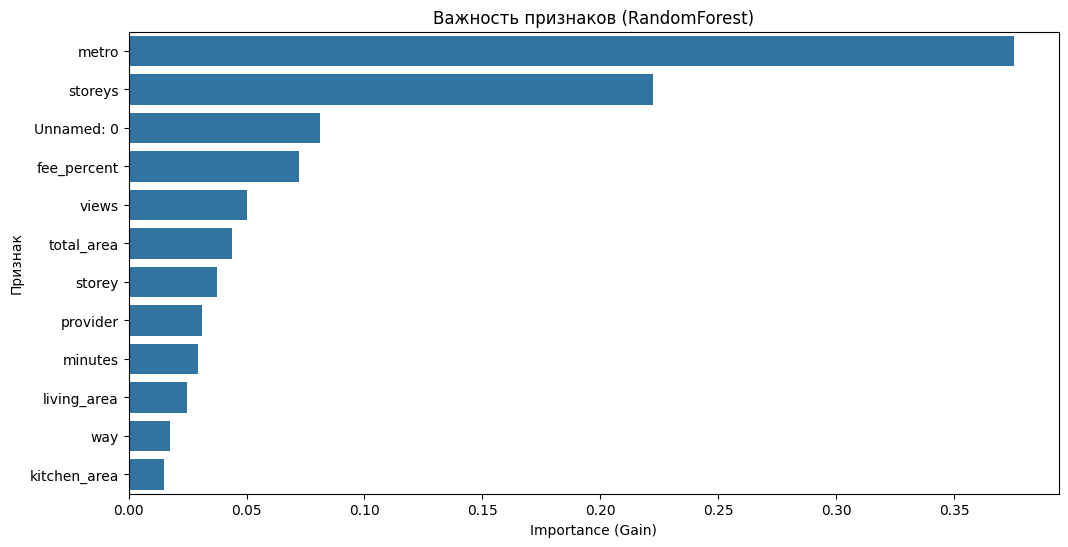

In [93]:
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': RandFor.feature_importances_
})

# Сортировка по важности
feature_importance_rf = feature_importance_rf.sort_values('importance', ascending=False)

# Визуализация топ-15 признаков
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_rf.head(15))
plt.title("Важность признаков (RandomForest)")
plt.xlabel("Importance (Gain)")
plt.ylabel("Признак")
plt.show()

# feature_importance_xgb = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': XGBoost.feature_importances_
# })

# # Сортировка по важности
# feature_importance = feature_importance.sort_values('importance', ascending=False)

# # Визуализация топ-15 признаков
# plt.figure(figsize=(12, 6))
# sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
# plt.title("Важность признаков (XGBoost)")
# plt.xlabel("Importance (Gain)")
# plt.ylabel("Признак")
# plt.show()

# feature_importance_extTr = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': ExtraTr.feature_importances_
# })

# # Сортировка по важности
# feature_importance = feature_importance.sort_values('importance', ascending=False)

# # Визуализация топ-15 признаков
# plt.figure(figsize=(12, 6))
# sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
# plt.title("Важность признаков (XGBoost)")
# plt.xlabel("Importance (Gain)")
# plt.ylabel("Признак")
# plt.show()